# Постановка задачи

Повторить и постараться улучшить результат статьи [Retip: Retention Time Prediction for Compound Annotation in Untargeted Metabolomics](https://pubs.acs.org/doi/abs/10.1021/acs.analchem.9b05765#)

# Подключение необходимых библиотек

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 11.8 MB/s eta 0:00:00


In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects
from rdkit.Chem import rdMolDescriptors

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import xgboost

import lightgbm

import openpyxl
from openpyxl import load_workbook

# Данные

## Общие мысли и информация из статьи

Для оценки правильности работы алгоритма набор данных разделяют на три части:

* **Обучающая выборка** (Training set) — выборка из данных, которая используется для обучения алгоритма.
* **Валидационная выборка** (Validation set) — выборка данных, которая используется для подбора параметров, выбора признаков и принятия других решений, касающихся обучения алгоритма.
* **Тестовая выборка** (Test set) — выборка, которая используется для оценки качества работы алгоритма, при этом никак не используется для обучения алгоритма или подбора используемых при этом обучении параметрам.



С учётом приведённой классификации не понятна таблица и логика, представленная авторами статьи. Почему они используют валидационную часть как тестовую и приводят значение метрики MAE на ней (которое существенно ниже, чем на тестовом множестве) как показатель эффективности произведённого исследования, для меня осталось пока непонятным.

Также не понятно, зачем приводить значение ошибки на тренировочном множестве, хотя по идее, алгоритмы обучались именно на этом множестве, поэтому ошибка должна стремиться к нулевому значению.

## Выделение дескрипторов

Процесс выделения дескриторов и добавления их к данным для удобства выделим в отдельную функцию. Отметим, что она будет возвращать два объекта - данные дескрипторов и соответствующие им метки.

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Avalon import pyAvalonTools


def get_descriptors(data):
    molecules = data.SMILES.apply(Chem.MolFromSmiles)
    morgan_generator = AllChem.GetMorganGenerator(radius=2)

    descriptor_list = []
    for mol in molecules:
        if mol is not None:
            morgan_fp = morgan_generator.GetFingerprint(mol)
            descriptor_list.append(morgan_fp.GetOnBits())
        else:
            descriptor_list.append([])

    data_descriptors = pd.DataFrame(descriptor_list)

    return data_descriptors.iloc[:, :-1]


## Данные, прикреплённые к статье, выложенные на [сайте](https://pubs.acs.org/doi/abs/10.1021/acs.analchem.9b05765#)

Название файла: `'ac9b05765_si_001.xlsx'`,
- тренировочные данные расположены в столбце `'Table_S1_Training_HILIC'`;
- тестовые данные расположены в столбце `'Table_S2_Test_HILIC'`;
- валидационные данные расположены в столбце `'Table_S3_HILIC_External'`.

In [ ]:
workbook = load_workbook('ac9b05765_si_001.xlsx')

Тестовые и тренировочные данные объединим в один набор данных:

In [ ]:
hilic_train = pd.DataFrame(workbook['Table_S1_Training_HILIC'].values)
hilic_train = hilic_train.loc[3:, [2, 3]]
hilic_train.columns = ['SMILES', 'Experimental Retention Time']

In [ ]:
hilic_train

,SMILES,Experimental Retention Time
3,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,2.019083
4,CC1C(NC(CN1)C2=CC=CC=C2)C,2.60795
5,C1CCC(C(C1)O)O,4.87655
6,C1CCC(=O)C(=O)C1,5.772267
7,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C,1.827733
...,...,...
878,CC1CC2=C(CCC(=O)C2)C3C1C4CCC(C4(CC3)C)(C#C)O,0.995283
879,C1=CC(=CC=C1C=CC2=CC(=CC(=C2)OC3C(C(C(C(O3)CO)...,4.640017
880,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,9.717716
881,C1CC(=O)C(C=C1)(C(=O)OCC2=CC=CC=C2OC3C(C(C(C(O...,1.507783


In [ ]:
hilic_test = pd.DataFrame(workbook['Table_S2_Test_HILIC'].values)
hilic_test = hilic_test.loc[3:, [5, 6]]
hilic_test.columns = ['SMILES', 'Experimental Retention Time']

In [ ]:
hilic_test

,SMILES,Experimental Retention Time
3,CC(C)(CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C)O,7.23
4,CCCC(=O)OC(CC(=O)[O-])C[N+](C)(C)C,5.77
5,CN1C(CCC1=O)C2=C[N+](=CC=C2)[O-],3.87
6,CN1C=NC2=C(C1=N)N=CN2C3C(C(C(O3)CO)O)O,7.46
7,CN1C(=O)C2=C(N=C1N)N(C=N2)C3C(C(C(O3)CO)O)O,5.84
...,...,...
141,CC(C(C(=O)NC(C)C(=O)[O-])[NH3+])O,8.56
142,CN1C(CC(C1=O)O)C2=CN=CC=C2,2.02
143,C1=CC=C2C(=C1)C(=CN2)CCN,6.92
144,C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N,6.92


In [ ]:
hilic_val = pd.DataFrame(workbook['Table_S3_HILIC_External'].values)
hilic_val = hilic_val.loc[3:, [2, 3]]
hilic_val.columns = ['SMILES', 'Experimental Retention Time']
hilic_val.index = range(377)

In [ ]:
hilic_val

,SMILES,Experimental Retention Time
0,C[C@@H]1[C@H]2[C@@H]([C@H]3[C@@H](C(=O)C(=C([C...,6.48
1,C1CCN[C@H](C1)[C@H](C2=CC(=NC3=C2C=CC=C3C(F)(F...,3.48
2,C[C@@H](CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2,4.54
3,C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N,6.51
4,CCN(CC)CCCCCCNC1=CC(=CC2=C(C=CN=C12)C)OC,2.3
...,...,...
372,CN(C)CC[C@@](C1=CC=CC2=CC=CC=C21)([C@H](C3=CC=...,1.89
373,COC1=C(C=C(C=C1)C2=NN(C(=O)[C@H]3[C@@H]2CC=CC3...,1.12
374,CC1(C(=NN(C1=O)C2CCCCCC2)C3=CC(=C(C=C3)OC)OCCC...,1.12
375,C[C@H](C1=CC=C(C=C1)OC2=CC=C(C=C2)OC)N(C)C3=NC...,4.57


In [ ]:
hilic = pd.concat([hilic_train, hilic_test, hilic_val], ignore_index=True)

In [ ]:
hilic

,SMILES,Experimental Retention Time
0,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,2.019083
1,CC1C(NC(CN1)C2=CC=CC=C2)C,2.60795
2,C1CCC(C(C1)O)O,4.87655
3,C1CCC(=O)C(=O)C1,5.772267
4,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C,1.827733
...,...,...
1395,CN(C)CC[C@@](C1=CC=CC2=CC=CC=C21)([C@H](C3=CC=...,1.89
1396,COC1=C(C=C(C=C1)C2=NN(C(=O)[C@H]3[C@@H]2CC=CC3...,1.12
1397,CC1(C(=NN(C1=O)C2CCCCCC2)C3=CC(=C(C=C3)OC)OCCC...,1.12
1398,C[C@H](C1=CC=C(C=C1)OC2=CC=C(C=C2)OC)N(C)C3=NC...,4.57


In [ ]:
xh_train = get_descriptors(hilic)

In [ ]:
xh_train

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,7,80,301,314,371,389,549,650.0,807.0,834.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,389,470,649,689,840,926,949.0,1019.0,1056.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,807,849,890,926,1019,1028,1041,1257.0,1304.0,1325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,310,314,650,751,926,1028,1380,1387.0,1711.0,1738.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18,314,322,400,504,564,650,758.0,771.0,801.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,3,80,114,155,237,275,378.0,389.0,401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1396,2,5,13,80,94,102,113,132.0,140.0,168.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1397,2,13,67,80,94,102,113,132.0,140.0,168.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398,1,193,260,283,322,328,378,409.0,512.0,600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
xh_train = pd.DataFrame(xh_train)

In [ ]:
xh_train = xh_train.iloc[:, :58]

In [ ]:
Xh = xh_train.fillna(0)

In [ ]:
Xh

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,7,80,301,314,371,389,549,650.0,807.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63,389,470,649,689,840,926,949.0,1019.0,1056.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,807,849,890,926,1019,1028,1041,1257.0,1304.0,1325.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,310,314,650,751,926,1028,1380,1387.0,1711.0,1738.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,314,322,400,504,564,650,758.0,771.0,801.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,3,80,114,155,237,275,378.0,389.0,401.0,...,1581.0,1624.0,1631.0,1750.0,1801.0,1842.0,1855.0,1873.0,1908.0,1951.0
1396,2,5,13,80,94,102,113,132.0,140.0,168.0,...,1325.0,1380.0,1385.0,1427.0,1428.0,1452.0,1518.0,1536.0,1750.0,1871.0
1397,2,13,67,80,94,102,113,132.0,140.0,168.0,...,1380.0,1385.0,1452.0,1518.0,1536.0,1750.0,1871.0,1873.0,1897.0,1910.0
1398,1,193,260,283,322,328,378,409.0,512.0,600.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
yh = hilic['Experimental Retention Time']

In [ ]:
yh = yh.apply(lambda x: x * 60)

### Стандартизация данных

In [ ]:
yh

,Experimental Retention Time
0,121.14498
1,156.47700
2,292.59300
3,346.33602
4,109.66398
...,...
1395,113.40000
1396,67.20000
1397,67.20000
1398,274.20000


In [ ]:
yh = np.array(yh)

In [ ]:
yh = yh.reshape(-1, 1)

In [ ]:
for i in yh:
  if i == 0:
    print(i)

In [ ]:
sc_h = StandardScaler()
yh_sc = sc_h.fit_transform(yh)

## Данные [HILIC positive data set](https://figshare.com/articles/dataset/HILIC_positive_data_set_/22088938/1)

Название файла: `pone.0280883.s005.xlsx`.

Предобработка состояла из следующих шагов:
- сопоставление названия химического соединения и его кодирования в формате SMILES;
- составление таблицы из двух столбцов `SMILES` и `'Experimental Retention Time'`;
- разделение на тренировочные, тестовые и валидационные данные.

In [ ]:
data_hp_begin = pd.read_excel('pone.0280883.s005.xlsx')
data_hp_begin = data_hp_begin[['Name', 'RT [min]']]

In [ ]:
import requests

identifiers  = data_hp_begin['Name']
smiles_df = pd.DataFrame(columns = ['Name', 'Smiles'])
for x in identifiers :
    url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + x + '/property/CanonicalSMILES/TXT'
    smiles = requests.get(url).text.rstrip()
    if('NotFound' in smiles):
        print(x, " not found")
    else:
        smiles_df = smiles_df._append({'Name' : x, 'Smiles' : smiles}, ignore_index = True)

N-[(1E)-1,3-Butadien-1-yl]-N-propylacetamide  not found
(3S,4S)-1-Butyl-3,4-piperidinediol  not found
3,4-Dichloro-5-oxo-2,5-dihydro-2-furanyl methyl carbonate  not found
3,4-Dichloro-5-oxo-2,5-dihydro-2-furanyl methyl carbonate  not found
2-(Trimethylammonio)butanoate  not found
1-[(1-Aminopropyl)amino]ethanethiol  not found
(E)-2-(3-Azidopropoxy)-2-hydroxyethenediazonium  not found
α-Lactose  not found
α-Lactose  not found
[Similar to: N'2-(2-furylcarbonyl)-3-chloro-4-methylthiophene-2-carbohydrazide; ΔMass: 9.9286 Da]  not found
2-(Trimethylammonio)butanoate  not found
Chloro(ethynyl)silane  not found
Chloro(ethynyl)silane  not found
[Similar to: N'2-(2-furylcarbonyl)-3-chloro-4-methylthiophene-2-carbohydrazide; ΔMass: 9.9289 Da]  not found
6-[(2-Aminoethyl)amino]-1,3-dimethyl-2,4(1H,3H)-pyrimidinedione  not found
3-Chloro-N-(1-phenylethyl)-1-propanamine  not found
[Similar to: N'2-(2-furylcarbonyl)-3-chloro-4-methylthiophene-2-carbohydrazide; ΔMass: 77.9157 Da]  not found
[Similar 

In [ ]:
data_hp = data_hp_begin.merge(smiles_df, how='left', on='Name')

In [ ]:
data_hp

,Name,RT [min],Smiles
0,L-Norleucine,7.176,CCCCC(C(=O)O)N
1,L-Norleucine,7.176,CCCCC(C(=O)O)N
2,L-Norleucine,6.933,CCCCC(C(=O)O)N
3,L-Norleucine,6.933,CCCCC(C(=O)O)N
4,"N-[(1E)-1,3-Butadien-1-yl]-N-propylacetamide",7.558,NaN
...,...,...,...
998,gamma-Glu-gln,7.119,C(CC(=O)NC(CCC(=O)N)C(=O)O)C(C(=O)O)N
999,gamma-Glu-gln,7.119,C(CC(=O)NC(CCC(=O)N)C(=O)O)C(C(=O)O)N
1000,gamma-Glu-gln,7.119,C(CC(=O)NC(CCC(=O)N)C(=O)O)C(C(=O)O)N
1001,glutaral,6.443,C(CC=O)CC=O


In [ ]:
result = data_hp.groupby('Name').agg({'RT [min]': 'mean', 'Smiles': 'first'}).reset_index()
result.columns = ['Name', 'RT [min]', 'Smiles']

In [ ]:
result

,Name,RT [min],Smiles
0,"(10R,11R)-4-Amino-10-hydroxy-11-methyl-12-oxa-...",7.6580,None
1,"(16alpha,17beta)-9-Fluoro-16-methyl-3,11-dioxo...",10.6480,None
2,"(1R)-1-{(1R,3R)-3-[2-(2,6-Diamino-9H-purin-9-y...",6.5090,None
3,"(1S,2S,3R,4S,5R,6R)-5-{[4-(4-Pyridinyl)benzyl]...",6.4980,None
4,"(1S,4S,5R,8S,9R,10S)-1,5,9-Trimethyl-11,14,15,...",6.4230,None
...,...,...,...
421,val-asn-gly-lys,7.8930,None
422,val-his,8.1590,CC(C)C(C(=O)NC(CC1=CN=CN1)C(=O)O)N
423,α-Lactose,7.7705,None
424,γ-Glutamyl-L-putrescine,14.9165,None


In [ ]:
result = result.dropna(subset=['Smiles'])

In [ ]:
result = pd.DataFrame(result)

In [ ]:
data_hp = result[~result['Smiles'].str.contains('Status')]

In [ ]:
data_hp

,Name,RT [min],Smiles
6,(2-Cyclohexen-1-ylsulfanyl)benzene,7.044500,C1CC=CC(C1)SC2=CC=CC=C2
19,(R)-Pantothenate,6.497000,CC(C)(CO)C(C(=O)NCCC(=O)O)O
20,(R)-Salsolinol,6.884500,CC1C2=CC(=C(C=C2CCN1)O)O\nCC1C2=CC(=C(C=C2CCN1...
21,(S)-2-Amino-3-hydroxypropanoate,12.146000,C(C(C(=O)O)N)O
23,"1,1-diethoxy-3-methylsulfanylpropane",7.020000,CCOC(CCSC)OCC
...,...,...,...
415,tert-Butyl N-[1-(aminocarbonyl)-3-methylbutyl]...,6.606000,CC(C)CC(C(=O)N)NC(=O)OC(C)(C)C
417,thr-arg,10.768000,CC(C(C(=O)NC(CCCN=C(N)N)C(=O)O)N)O
418,thr-his,8.655333,CC(C(C(=O)NC(CC1=CN=CN1)C(=O)O)N)O
420,tyr-his,8.016500,C1=CC(=CC=C1CC(C(=O)NC(CC2=CN=CN2)C(=O)O)N)O


In [ ]:
data_hp.index = range(275)

In [ ]:
data_hp = data_hp[['Smiles', 'RT [min]']]
data_hp.columns = ['SMILES', 'Experimental Retention Time']

In [ ]:
data_hp

,SMILES,Experimental Retention Time
0,C1CC=CC(C1)SC2=CC=CC=C2,7.044500
1,CC(C)(CO)C(C(=O)NCCC(=O)O)O,6.497000
2,CC1C2=CC(=C(C=C2CCN1)O)O\nCC1C2=CC(=C(C=C2CCN1...,6.884500
3,C(C(C(=O)O)N)O,12.146000
4,CCOC(CCSC)OCC,7.020000
...,...,...
270,CC(C)CC(C(=O)N)NC(=O)OC(C)(C)C,6.606000
271,CC(C(C(=O)NC(CCCN=C(N)N)C(=O)O)N)O,10.768000
272,CC(C(C(=O)NC(CC1=CN=CN1)C(=O)O)N)O,8.655333
273,C1=CC(=CC=C1CC(C(=O)NC(CC2=CN=CN2)C(=O)O)N)O,8.016500


In [ ]:
np.any(data_hp.isna().values)

False

In [ ]:
xhp_train = get_descriptors(data_hp)

In [ ]:
xhp_train = pd.DataFrame(xhp_train)

In [ ]:
xhp_train = xhp_train.iloc[:, :58]

In [ ]:
Xhp = xhp_train.fillna(0)

In [ ]:
Xhp

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,27,39,116,389,391,690,765.0,811.0,926.0,983.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,33,80,114,115,197,222.0,227.0,358.0,363.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,87,250,305,568,589,735.0,807.0,875.0,924.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,80,222,389,482,650,786.0,807.0,1171.0,1268.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,11,80,116,294,316,387.0,394.0,612.0,695.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,1,80,89,114,117,140,231.0,283.0,392.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271,1,80,117,140,144,227,262.0,283.0,343.0,351.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272,1,79,80,94,117,188,227.0,262.0,283.0,378.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,1,79,80,94,117,188,310.0,378.0,389.0,573.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
yhp = data_hp['Experimental Retention Time']

In [ ]:
yhp = yhp.apply(lambda x: x * 60)

In [ ]:
yhp

,Experimental Retention Time
0,422.67
1,389.82
2,413.07
3,728.76
4,421.20
...,...
270,396.36
271,646.08
272,519.32
273,480.99


Стандартизация предсказываемого значения:

In [ ]:
yhp = np.array(yhp)
yhp = yhp.reshape(-1, 1)
sc_hp = StandardScaler()
yhp_sc = sc_hp.fit_transform(yhp)

## Данные Plasma positive из [GitHub авторов](https://github.com/PaoloBnn/Retip/blob/master/examples/Plasma_positive.xlsx)

Название файла: `Plasma_positive.xlsx`

In [ ]:
workbook = load_workbook('Plasma_positive.xlsx')

In [ ]:
pp_begin_train = pd.DataFrame(workbook['lib'].values)
pp_begin_train = pp_begin_train.loc[1:, [2, 3]]

In [ ]:
pp_begin_train

,2,3
1,CC(C1CC(C)=C(C)C(=O)O1)C1(O)CCC2C3C4OC4C4(O)CC...,6.82
2,CC1CCC2(CCC3(C)C(=CCC4C5(C)CC(O)C(O)C(C)(C)C5C...,9.89
3,CC1(C)CCC2(CCC3(C)C(=CCC4C5(C)CC(O)C(O)C(C)(C)...,9.77
4,CC1(C)CC2C3=CCC4C5(C)CCC(O)C(C)(CO)C5CCC4(C)C3...,8.94
5,CC(C)=CCC=C(C)C1CCC2(C)C1C(O)CC1C3(C)CCC(OC4OC...,7.63
...,...,...
437,COC1=CC(=CC=C1O)C1=C(OC2OC(CO)C(O)C(O)C2O)C=C2...,3.19
438,OC1=CC=C(C=C1)C1=[O+]C2=CC(O)=CC([O-])=C2C=C1,3.87
439,OC(=O)CCC(N=C(O)CC1=CNC2=CC=CC=C12)C(O)=O,4.12
440,O=C1CNC(=O)C2CCCN12,2.06


In [ ]:
pp_begin_train.columns = ['SMILES', 'Experimental Retention Time']
pp_begin_train.index = range(441)

In [ ]:
pp_begin_test = pd.DataFrame(workbook['ext'].values)
pp_begin_test = pp_begin_test.loc[1:, [2, 3]]
pp_begin_test.columns = ['SMILES', 'Experimental Retention Time']
pp_begin_test.index = range(358)

In [ ]:
pp_begin_val = pd.DataFrame(workbook['neg1'].values)
pp_begin_val = pp_begin_val.loc[1:, [2, 3]]
pp_begin_val.columns = ['SMILES', 'Experimental Retention Time']
pp_begin_val.index = range(409)
xpp_val = get_descriptors(pp_begin_val)

In [ ]:
plasma_positive = pd.concat([pp_begin_train, pp_begin_test, pp_begin_val], ignore_index=True)

In [ ]:
plasma_positive

,SMILES,Experimental Retention Time
0,CC(C1CC(C)=C(C)C(=O)O1)C1(O)CCC2C3C4OC4C4(O)CC...,6.82
1,CC1CCC2(CCC3(C)C(=CCC4C5(C)CC(O)C(O)C(C)(C)C5C...,9.89
2,CC1(C)CCC2(CCC3(C)C(=CCC4C5(C)CC(O)C(O)C(C)(C)...,9.77
3,CC1(C)CC2C3=CCC4C5(C)CCC(O)C(C)(CO)C5CCC4(C)C3...,8.94
4,CC(C)=CCC=C(C)C1CCC2(C)C1C(O)CC1C3(C)CCC(OC4OC...,7.63
...,...,...
1203,OCC1OC(OC2=C([O+]=C3C=C(O)C=C(O)C3=C2)C2=CC(O)...,2.85
1204,COC1=CC(=CC=C1O)C1=C(OC2OC(CO)C(O)C(O)C2O)C=C2...,3.2
1205,COC1=CC(=CC(O)=C1O)C1=[O+]C2=C(C=C1OC1OC(CO)C(...,4.38
1206,CC(NC(=O)CC1=CNC2=C1C=CC=C2)C(O)=O,4.53


In [ ]:
xpp_train = get_descriptors(plasma_positive)

In [ ]:
xpp_train

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,1,21,61,182,221,231,279,283,314,362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,184,198,267,375,389,409,418,478,528,549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,184,198,267,389,409,418,478,549,555,598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80,102,175,222,267,322,347,409,418,478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22,80,175,209,222,249,267,478,479,489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,80,136,167,222,315,489,524,589,607,610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1204,80,136,167,222,249,489,524,607,610,614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1205,80,136,167,202,222,249,489,524,610,656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1206,1,41,80,117,119,255,283,296,322,325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
xpp_train = pd.DataFrame(xpp_train)
xpp_train = xpp_train.iloc[:, :58]
xpp_train= xpp_train.fillna(0)
Xpp = pd.DataFrame(xpp_train)
Xpp

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,1,21,61,182,221,231,279,283,314,362,...,1380.0,1436.0,1576.0,1626.0,1722.0,1769.0,1816.0,1847.0,1873.0,1921.0
1,184,198,267,375,389,409,418,478,528,549,...,1885.0,1917.0,2005.0,2036.0,0.0,0.0,0.0,0.0,0.0,0.0
2,184,198,267,389,409,418,478,549,555,598,...,2034.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80,102,175,222,267,322,347,409,418,478,...,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,80,175,209,222,249,267,478,479,489,...,1516.0,1582.0,1590.0,1632.0,1714.0,1753.0,1764.0,1844.0,1873.0,1889.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,80,136,167,222,315,489,524,589,607,610,...,2014.0,2041.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1204,80,136,167,222,249,489,524,607,610,614,...,1879.0,1921.0,1970.0,1977.0,2014.0,2041.0,0.0,0.0,0.0,0.0
1205,80,136,167,202,222,249,489,524,610,656,...,1970.0,1977.0,2014.0,2021.0,2041.0,0.0,0.0,0.0,0.0,0.0
1206,1,41,80,117,119,255,283,296,322,325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ypp = plasma_positive['Experimental Retention Time']

In [ ]:
ypp = ypp.apply(lambda x: x * 60)

In [ ]:
ypp = np.array(ypp)

In [ ]:
ypp = ypp.reshape(-1, 1)

In [ ]:
sc_pp = StandardScaler()
ypp_sc = sc_pp.fit_transform(ypp)

### Объединение всех данных в один набор

In [ ]:
X_all = pd.concat([Xh, Xhp, Xpp], ignore_index=True)

In [ ]:
X_all

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,7,80,301,314,371,389,549.0,650.0,807.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63,389,470,649,689,840,926.0,949.0,1019.0,1056.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,807,849,890,926,1019,1028,1041.0,1257.0,1304.0,1325.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,310,314,650,751,926,1028,1380.0,1387.0,1711.0,1738.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,314,322,400,504,564,650.0,758.0,771.0,801.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,80,136,167,222,315,489,524.0,589.0,607.0,610.0,...,2014.0,2041.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2879,80,136,167,222,249,489,524.0,607.0,610.0,614.0,...,1879.0,1921.0,1970.0,1977.0,2014.0,2041.0,0.0,0.0,0.0,0.0
2880,80,136,167,202,222,249,489.0,524.0,610.0,656.0,...,1970.0,1977.0,2014.0,2021.0,2041.0,0.0,0.0,0.0,0.0,0.0
2881,1,41,80,117,119,255,283.0,296.0,322.0,325.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_all = pd.concat([hilic['Experimental Retention Time'], data_hp['Experimental Retention Time'], plasma_positive['Experimental Retention Time']], ignore_index=True)

In [ ]:
y_all

,Experimental Retention Time
0,2.019083
1,2.60795
2,4.87655
3,5.772267
4,1.827733
...,...
2878,2.85
2879,3.2
2880,4.38
2881,4.53


In [ ]:
y_all = y_all.apply(lambda x: x * 60)

In [ ]:
y_all = np.array(y_all)

In [ ]:
y_all = y_all.reshape(-1, 1)

In [ ]:
sc_all = StandardScaler()
y_all_sc = sc_all.fit_transform(y_all)

## Данные METLIN_8_25

Название файла: `METLIN_8_25_to_OHE`.

Предобработка состояла из следующих шагов:
- сопоставление названия химического соединения и его кодирования в формате SMILES;
- составление таблицы из двух столбцов `SMILES` и `'Experimental Retention Time'`;
- разделение на тренировочные, тестовые и валидационные данные.

In [ ]:
metlin_8_25_begin = pd.read_csv('METLIN_8_25_to_OHE_to_CNN')
metlin_8_25_begin.columns = ['SMILES', 'Experimental Retention Time']

In [ ]:
metlin_8_25_begin

,SMILES,Experimental Retention Time
0,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,11.463333
1,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1O...,9.845000
2,Oc1cccc2c(O)nccc12 ...,9.726667
3,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1 ...,9.650000
4,CC(C)(C)NC[C@H](O)COc1cccc2nc(O)[nH]c12 ...,10.051667
...,...,...
77884,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,15.773333
77885,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,10.885000
77886,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,10.803333
77887,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,13.065000


In [ ]:
metlin_8_25_train = get_descriptors(metlin_8_25_begin)

In [ ]:
metlin_8_25_train = pd.DataFrame(metlin_8_25_train )

In [ ]:
metlin_8_25_train  = metlin_8_25_train .iloc[:, :58]

In [ ]:
Xm_8_25 = metlin_8_25_train .fillna(0)

In [ ]:
Xm_8_25

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,80,119,242,310,321,325,366,384,509,561,...,1998.0,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34,71,80,249,269,283,294,350,389,392,...,1991.0,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,106,378,400,440,787,807,843,1039,1088,1357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80,218,280,378,389,583,611,656,807,812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,80,89,114,118,170,227,289,307,378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77884,4,25,69,80,92,94,199,237,248,294,...,1542.0,1613.0,1637.0,1665.0,1722.0,1750.0,1752.0,1785.0,1790.0,1802.0
77885,13,80,144,149,230,272,308,319,350,389,...,1873.0,1911.0,1921.0,1928.0,2004.0,2009.0,0.0,0.0,0.0,0.0
77886,13,80,144,149,272,308,319,350,389,486,...,1873.0,1921.0,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77887,18,149,235,308,319,350,374,389,585,650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ym_8_25 = metlin_8_25_begin['Experimental Retention Time']

In [ ]:
ym_8_25 = ym_8_25.apply(lambda x: x * 60)

In [ ]:
ym_8_25

,Experimental Retention Time
0,687.8
1,590.7
2,583.6
3,579.0
4,603.1
...,...
77884,946.4
77885,653.1
77886,648.2
77887,783.9


Стандартизация предсказываемого значения:

In [ ]:
ym_8_25 = np.array(ym_8_25)
ym_8_25 = ym_8_25.reshape(-1, 1)
sc_m_8_25 = StandardScaler()
ym_8_25_sc = sc_m_8_25.fit_transform(ym_8_25)

## Данные METLIN_0_8

Название файла: `METLIN_0_8_to_OHE`.

Предобработка состояла из следующих шагов:
- сопоставление названия химического соединения и его кодирования в формате SMILES;
- составление таблицы из двух столбцов `SMILES` и `'Experimental Retention Time'`;
- разделение на тренировочные, тестовые и валидационные данные.

In [ ]:
metlin_0_8_begin = pd.read_csv('METLIN_0_8_to_OHE_to_CNN')
metlin_0_8_begin.columns = ['SMILES', 'Experimental Retention Time']

In [ ]:
metlin_0_8_begin

,SMILES,Experimental Retention Time
0,CCSC(=N)N ...,1.558333
1,CCN1CCc2[nH]c(=N)oc2CC1 ...,1.328333
2,CN1CCC(c2c[nH]c3ccc(O)cc23)CC1 ...,1.570000
3,N[C@H]1CCc2cc(O)c(O)cc2C1 ...,1.525000
4,NNC(=O)c1ccc(O)cc1 ...,1.936667
...,...,...
2063,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NC2CCN(C)CC...,1.398333
2064,CCC(=O)N1CCN([C@H]2CCN(CCN(C)C)C2=O)CC1 ...,1.315000
2065,Cc1oc2c(c1C(O)=NCCCn1cccn1)CN(C)CC2 ...,1.350000
2066,Cc1cnc(C(O)=N[C@@H]2CCC[C@@H]2C(O)=NCCN2CCOCC2...,1.365000


In [ ]:
metlin_0_8_train = get_descriptors(metlin_0_8_begin)

In [ ]:
metlin_0_8_train = pd.DataFrame(metlin_0_8_train )

In [ ]:
metlin_0_8_train  = metlin_0_8_train .iloc[:, :58]

In [ ]:
Xm_0_8 = metlin_0_8_train .fillna(0)

In [ ]:
Xm_0_8

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,80,116,140,165,294,623,653.0,807.0,910.0,1057.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34,80,245,294,435,502,507.0,623.0,656.0,676.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,119,207,328,381,558,745,802.0,806.0,807.0,875.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,231,346,589,713,735,807.0,867.0,875.0,926.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,80,486,650,745,807,1152,1171.0,1313.0,1380.0,1385.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,35,207,209,247,269,356,378.0,389.0,514.0,563.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2064,5,76,80,148,294,314,650.0,652.0,693.0,760.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2065,43,75,77,80,144,207,242.0,269.0,294.0,356.0,...,2030.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2066,35,70,80,144,209,247,269.0,356.0,378.0,389.0,...,1895.0,1997.0,2047.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ym_0_8 = metlin_0_8_begin['Experimental Retention Time']

In [ ]:
ym_0_8 = ym_0_8.apply(lambda x: x * 60)

In [ ]:
ym_0_8

,Experimental Retention Time
0,93.5
1,79.7
2,94.2
3,91.5
4,116.2
...,...
2063,83.9
2064,78.9
2065,81.0
2066,81.9


Стандартизация предсказываемого значения:

In [ ]:
ym_0_8 = np.array(ym_0_8)
ym_0_8 = ym_0_8.reshape(-1, 1)
sc_m_0_8 = StandardScaler()
ym_0_8_sc = sc_m_0_8.fit_transform(ym_0_8)

# Метрики

В качестве метрик выберем классические метрики для задачи регрессии - MAE, MSE, RMSE. Авторы статьи используют только первую метрику, но мы будем использовать все три для более полного анализа эффективности работы алгоритмов.

Выделим вычисление и вывод всех метрик на экран в виде отдельной функции `print_metrics`:

In [ ]:
def print_metrics(y_true, y_predicted):
    print(f"Mean absolute error: {mean_absolute_error(y_true, y_predicted):.3f}")
    print(f"Mean squared error: {mean_squared_error(y_true, y_predicted):.3f}")
    print(f"Root mean squared error: {mean_squared_error(y_true, y_predicted, squared=False):.3f}")

# Методы

## Информация о методах и подборе гиперпарметров из статьи:

Авторы статьи пишут о применении 5 алгоритмов для решения поставленной задачи:

"Five different machine learning algorithms have been integrated into the Retip R package: the random forest, Bayesian-regularized neural network, XGBoost, light gradient-boosting machine (LightGBM) and Keras algorithms for building the retention time prediction models. "

К каждому алгоритму была применена процедура подбора оптимального значения гиперпараметров:

(1) XGBoost21 performs gradient-boosting for regression and classification problems. We implemented automatic grid search tuning for the parameters nrounds, max_depth, and eta, while the fixed parameters were gamma, colsample_bytree, subsample and min_child_weight.

(2) Keras is a high-abstraction layer available for GPU and CPU processing for deep learning and neural networks, using TensorFlow, the Microsoft Cognitive Toolkit and Theano libraries. Data were centered and scaled. We automatically tuned the dense_unit, epochs and dropout parameters; other parameters as batch_size and learning_rate were manually tuned.

(3) The light gradient-boosting machine (LightGBM)22 is known for its high efficiency and low RAM usage. It can efficiently process millions of rows in parallel. For parameter optimization, Retip automatically searches for the optimal nrounds parameter based on the best iter value in the cross-validation model. Other model values, such as regression L1 and L2 regularization, the learning rate, eval_freq, metric, early_stopping_rounds, maximum depth, maximum leaf, maximum bin were manually tuned to identify the best values and deal with overfitting.

(4) The random forest (RF) algorithm23 is one of the most popular algorithms in machine learning. We tuned the mtry parameter, which describes the number of variables that are sampled as candidates for each split.

(5) We tuned the number of neurons for the Bayesian-regularized neural network (BRNN)24 , an algorithm that uses Bayesian regularization for feedforward neural networks.

[Код авторов на R](https://github.com/PaoloBnn/Retip/blob/master/examples/workflow_PlaSMA.R)

## Реализация методов

Цитата из статьи: The training and testing splits were made in the ratio 42 of 80:20, respectively, with the caret package in R27 43 using XlogP as the index. Each model was trained 44 with 10-fold cross validation.

### XBoost без стандартизации

(1) XGBoost21 performs gradient-boosting for regression and classification problems. We implemented automatic grid search tuning for the parameters nrounds, max_depth, and eta, while the fixed parameters were gamma, colsample_bytree, subsample and min_child_weight.

#### XBoost на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    xgb_h = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh[train_index], yh[test_index]
    xgb_h.fit(X_train, y_train)
    y_pred = xgb_h.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 120.2870514118164
MAE по каждому фолду: [120.81210340159913, 126.6939830135934, 115.24402396240933, 119.91448261297433, 118.77066406850588]


#### XBoost на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    xgb_hp = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp[train_index], yhp[test_index]
    xgb_hp.fit(X_train, y_train)
    y_pred = xgb_hp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 81.90661895285866
MAE по каждому фолду: [74.80760482510654, 70.5285941850142, 61.147682776988624, 93.98836891645954, 109.06084406072445]


#### XBoost на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    xgb_pp = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp[train_index], ypp[test_index]
    xgb_pp.fit(X_train, y_train)
    y_pred = xgb_pp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 66.55608143406785
MAE по каждому фолду: [63.031205282920645, 75.35116636418113, 61.928684871452894, 66.31646333433285, 66.1528873174517]


#### XBoost на объединении всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    xgb_all = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all[train_index], y_all[test_index]
    xgb_all.fit(X_train, y_train)
    y_pred = xgb_all.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 116.15702413171581
MAE по каждому фолду: [112.68600389942928, 118.60831309242478, 108.37491098099173, 120.52561009468587, 120.5902825910475]


#### XBoost на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    xgb_m_0_8 = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8[train_index], ym_0_8[test_index]
    xgb_m_0_8.fit(X_train, y_train)
    y_pred = xgb_m_0_8.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 10.405495013928391
MAE по каждому фолду: [10.068926365119367, 9.18282855325494, 11.678581300845815, 10.8541693279852, 10.242969522436622]


#### XBoost на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    xgb_m_8_25 = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25[train_index], ym_8_25[test_index]
    xgb_m_8_25.fit(X_train, y_train)
    y_pred = xgb_m_8_25.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 129.60243253565102
MAE по каждому фолду: [122.220703125, 132.7494880108794, 135.822040904652, 125.67816607843297, 131.54176455929073]


### XBoost на данных после Standart Scaler

(1) XGBoost21 performs gradient-boosting for regression and classification problems. We implemented automatic grid search tuning for the parameters nrounds, max_depth, and eta, while the fixed parameters were gamma, colsample_bytree, subsample and min_child_weight.

#### XBoost на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    xgb_h_sc = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh_sc[train_index], yh_sc[test_index]
    xgb_h_sc.fit(X_train, y_train)
    y_pred = xgb_h_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.7160755927599396
MAE по каждому фолду: [0.7192012458215731, 0.754216384358077, 0.6860541688555452, 0.7138576794142607, 0.7070484853502423]


#### XBoost на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    xgb_hp_sc = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp_sc[train_index], yhp_sc[test_index]
    xgb_hp_sc.fit(X_train, y_train)
    y_pred = xgb_hp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.6883353499424987
MAE по каждому фолду: [0.6286759316924861, 0.5927154776750435, 0.5138794066311066, 0.7898692775752647, 0.9165366561385924]


#### XBoost на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    xgb_pp_sc = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp_sc[train_index], ypp_sc[test_index]
    xgb_pp_sc.fit(X_train, y_train)
    y_pred = xgb_pp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.5737237777760211
MAE по каждому фолду: [0.5433387838745224, 0.6495388693779898, 0.533834841278119, 0.5716582563006131, 0.5702481380488615]


#### XBoost на объединении всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    xgb_all_sc = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all_sc[train_index], y_all_sc[test_index]
    xgb_all_sc.fit(X_train, y_train)
    y_pred = xgb_all_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.7317783937180621
MAE по каждому фолду: [0.7099558582303713, 0.7388010186231176, 0.6955030906024879, 0.7587403191092292, 0.7558916820251044]


#### XBoost на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    xgb_m_0_8_sc = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8_sc[train_index], ym_0_8_sc[test_index]
    xgb_m_0_8_sc.fit(X_train, y_train)
    y_pred = xgb_m_0_8_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.40226350414979306
MAE по каждому фолду: [0.3892521283974467, 0.35499673031077056, 0.451479348919716, 0.41960872059644505, 0.39598059252458684]


#### XBoost на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    xgb_m_8_25_sc = xgb.XGBRFRegressor(random_state=46)
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25_sc[train_index], ym_8_25_sc[test_index]
    xgb_m_8_25_sc.fit(X_train, y_train)
    y_pred = xgb_m_8_25_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.7422328427635905
MAE по каждому фолду: [0.699957640582709, 0.7602561039985083, 0.7778525560470162, 0.719758494226589, 0.7533394189631301]


### MLPRegressor без стандартизации

(2) Keras is a high-abstraction layer available for GPU and CPU processing for deep learning and neural networks, using TensorFlow, the Microsoft Cognitive Toolkit and Theano libraries. Data were centered and scaled. We automatically tuned the dense_unit, epochs and dropout parameters; other parameters as batch_size and learning_rate were manually tuned.

Если опираться на код авторов, написанный на языке R, для этой модели аналогом будет модель `MLPRegressor`. Забегая вперёд, отмечу, что модель отказалась улучшать параметры и сходиться при использовании `GridSearch`. Также качество этой модели несколько хуже, чем у других моделей.

#### MLPRegressor на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    mlp_h = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh[train_index], yh[test_index]
    mlp_h.fit(X_train, y_train.ravel())
    y_pred = mlp_h.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 133.3131705073218
MAE по каждому фолду: [135.4439254521939, 139.75217896163443, 132.74719735597304, 128.6263851627949, 129.9961656040126]


#### MLPRegressor на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    mlp_hp = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp[train_index], yhp[test_index]
    mlp_hp.fit(X_train, y_train.ravel())
    y_pred = mlp_hp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 105.45587910722438
MAE по каждому фолду: [91.52587168087001, 104.08680222223481, 90.33598473661569, 113.96035540162909, 127.37038149477223]


#### MLPRegressor на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    mlp_pp = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp[train_index], ypp[test_index]
    mlp_pp.fit(X_train, y_train.ravel())
    y_pred = mlp_pp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 87.88968867608737
MAE по каждому фолду: [86.77274514394702, 92.58578507851486, 87.1125524938897, 87.28267922378525, 85.69468144030004]


#### MLPRegressor на объединении всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    mlp_all = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all[train_index], y_all[test_index]
    mlp_all.fit(X_train, y_train.ravel())
    y_pred = mlp_all.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 128.33826912668874
MAE по каждому фолду: [120.20255501973395, 125.04289355762982, 121.49942560662653, 134.2097709552525, 140.73670049420082]


#### MLPRegressor на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    mlp_m_0_8 = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8[train_index], ym_0_8[test_index]
    mlp_m_0_8.fit(X_train, y_train.ravel())
    y_pred = mlp_m_0_8.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 21.5722115448979
MAE по каждому фолду: [20.13139485386412, 19.167699381932625, 20.063844827007664, 22.91190987558162, 25.58620878610347]


#### MLPRegressor на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    mlp_m_8_25 = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25[train_index], ym_8_25[test_index]
    mlp_m_8_25.fit(X_train, y_train.ravel())
    y_pred = mlp_m_8_25.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 139.83902757370362
MAE по каждому фолду: [140.57194653133033, 140.8203739611966, 138.05983976862308, 133.0044978831335, 146.73847972423457]


### MLPRegressor с использованием стандартизации Standart Sacaler

(2) Keras is a high-abstraction layer available for GPU and CPU processing for deep learning and neural networks, using TensorFlow, the Microsoft Cognitive Toolkit and Theano libraries. Data were centered and scaled. We automatically tuned the dense_unit, epochs and dropout parameters; other parameters as batch_size and learning_rate were manually tuned.

Если опираться на код авторов, написанный на языке R, для этой модели аналогом будет модель `MLPRegressor`. Забегая вперёд, отмечу, что модель отказалась улучшать параметры и сходиться при использовании `GridSearch`. Также качество этой модели несколько хуже, чем у других моделей.

#### MLPRegressor на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    mlp_h_sc = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh_sc[train_index], yh_sc[test_index]
    mlp_h_sc.fit(X_train, y_train.ravel())
    y_pred = mlp_h_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 13.49953311686708
MAE по каждому фолду: [14.410593301679524, 13.397309022428146, 14.133493445636438, 12.486767376104753, 13.069502438486534]


#### MLPRegressor на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    mlp_hp_sc = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp_sc[train_index], yhp_sc[test_index]
    mlp_hp_sc.fit(X_train, y_train.ravel())
    y_pred = mlp_hp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 25.965444454312404
MAE по каждому фолду: [30.226358750056992, 22.455427372323147, 30.34199921466196, 20.763356925404775, 26.040080009115137]


#### MLPRegressor на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    mlp_pp_sc = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp_sc[train_index], ypp_sc[test_index]
    mlp_pp_sc.fit(X_train, y_train.ravel())
    y_pred = mlp_pp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 13.48544810683037
MAE по каждому фолду: [13.825852654893758, 13.936582811732864, 12.377435334722628, 15.24686885461032, 12.040500878192288]


#### MLPRegressor на объединении всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    mlp_all_sc = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all_sc[train_index], y_all_sc[test_index]
    mlp_all_sc.fit(X_train, y_train.ravel())
    y_pred = mlp_all_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 9.99409177886996
MAE по каждому фолду: [9.006178165093923, 9.707658119466554, 10.393875658144845, 11.262640155851837, 9.600106795792634]


#### MLPRegressor на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    mlp_m_0_8_sc = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8_sc[train_index], ym_0_8_sc[test_index]
    mlp_m_0_8_sc.fit(X_train, y_train.ravel())
    y_pred = mlp_m_0_8_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 15.954696032116889
MAE по каждому фолду: [14.188377965447334, 19.281134325017746, 15.208117559908924, 13.951340563057897, 17.14450974715254]


#### MLPRegressor на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    mlp_m_8_25_sc = MLPRegressor(random_state=46, max_iter=1000)
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25_sc[train_index], ym_8_25_sc[test_index]
    mlp_m_8_25_sc.fit(X_train, y_train.ravel())
    y_pred = mlp_m_8_25_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 15.715039896650532
MAE по каждому фолду: [18.48641832253118, 14.323660338777023, 13.95846908357827, 19.047127132582983, 12.759524605783202]


### LightGBM без стандартизации

(3) The light gradient-boosting machine (LightGBM)22 is known for its high efficiency and low RAM usage. It can efficiently process millions of rows in parallel. For parameter optimization, Retip automatically searches for the optimal nrounds parameter based on the best iter value in the cross-validation model. Other model values, such as regression L1 and L2 regularization, the learning rate, eval_freq, metric, early_stopping_rounds, maximum depth, maximum leaf, maximum bin were manually tuned to identify the best values and deal with overfitting.

#### LightGBM на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    l_h = lightgbm.LGBMRegressor()
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh[train_index], yh[test_index]
    l_h.fit(X_train, y_train.ravel())
    y_pred = l_h.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10350
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 58
[LightGBM] [Info] Start training from score 217.307047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10290
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 58
[LightGBM] [Info] Start training from score 213.197106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 110.33230532012776
MAE по каждому фолду: [112.82609560972948, 113.23164602050308, 106.88240225570698, 111.37261770675778, 107.34876500794151]


#### LightGBM на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    l_hp = lightgbm.LGBMRegressor()
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp[train_index], yhp[test_index]
    l_hp.fit(X_train, y_train.ravel())
    y_pred = l_hp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 39
[LightGBM] [Info] Start training from score 446.608342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 87.37711671311618
MAE по каждому фолду: [89.84594910870975, 79.83511278550849, 67.03315953303078, 95.92423038010138, 104.2471317582305]


#### LightGBM на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    l_pp = lightgbm.LGBMRegressor()
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp[train_index], ypp[test_index]
    l_pp.fit(X_train, y_train.ravel())
    y_pred = l_pp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6559
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 283.855279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 289.466460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 45.39085512389048
MAE по каждому фолду: [44.62827252609628, 50.785338274119766, 46.32864744622953, 41.90877832742934, 43.30323904557751]


#### LightGBM на наборе, полученном объединением всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    l_all = lightgbm.LGBMRegressor()
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all[train_index], y_all[test_index]
    l_all.fit(X_train, y_train.ravel())
    y_pred = l_all.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12547
[LightGBM] [Info] Number of data points in the train set: 2306, number of used features: 58
[LightGBM] [Info] Start training from score 270.036942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12647
[LightGBM] [Info] Number of data points in the train set: 2306, number of used features: 58
[LightGBM] [Info] Start training from score 271.080632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 104.62893174864087
MAE по каждому фолду: [100.6353238140119, 106.21151109366308, 94.78294385286517, 112.97982085703637, 108.53505912562777]


#### LightGBM на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    l_m_0_8 = lightgbm.LGBMRegressor()
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8[train_index], ym_0_8[test_index]
    l_m_0_8.fit(X_train, y_train.ravel())
    y_pred = l_m_0_8.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9826
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 91.277743
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9710
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 91.421946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 12.1926081824665
MAE по каждому фолду: [11.679792813734881, 11.58855718940064, 12.746704531502068, 12.30242071791602, 12.64556565977889]


#### LightGBM на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    l_m_8_25 = lightgbm.LGBMRegressor()
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25[train_index], ym_8_25[test_index]
    l_m_8_25.fit(X_train, y_train.ravel())
    y_pred = l_m_8_25.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9827
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 788.831055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9702
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 790.688508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 128.6187244793467
MAE по каждому фолду: [120.53859895981826, 135.02712215113473, 132.86383557428292, 123.77184700023649, 130.89221871126114]


### LightGBM с использованием стандартизации Standart Scaler

(3) The light gradient-boosting machine (LightGBM)22 is known for its high efficiency and low RAM usage. It can efficiently process millions of rows in parallel. For parameter optimization, Retip automatically searches for the optimal nrounds parameter based on the best iter value in the cross-validation model. Other model values, such as regression L1 and L2 regularization, the learning rate, eval_freq, metric, early_stopping_rounds, maximum depth, maximum leaf, maximum bin were manually tuned to identify the best values and deal with overfitting.

#### LightGBM на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    l_h_sc = lightgbm.LGBMRegressor()
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh_sc[train_index], yh_sc[test_index]
    l_h_sc.fit(X_train, y_train.ravel())
    y_pred = l_h_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10350
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 58
[LightGBM] [Info] Start training from score -0.003577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10290
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 58
[LightGBM] [Info] Start training from score -0.028044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.6568144214997252
MAE по каждому фолду: [0.6716600945740471, 0.6740743609314797, 0.6362769546681051, 0.6630074581619857, 0.6390532391630087]


#### LightGBM на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    l_hp_sc = lightgbm.LGBMRegressor()
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp_sc[train_index], yhp_sc[test_index]
    l_hp_sc.fit(X_train, y_train.ravel())
    y_pred = l_hp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 39
[LightGBM] [Info] Start training from score -0.004944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.7343089915404498
MAE по каждому фолду: [0.7550568241638314, 0.6709267177321484, 0.5633403066560311, 0.8061381181286611, 0.8760829910215768]


#### LightGBM на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    l_pp_sc = lightgbm.LGBMRegressor()
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp_sc[train_index], ypp_sc[test_index]
    l_pp_sc.fit(X_train, y_train.ravel())
    y_pred = l_pp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6559
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score -0.034217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 0.014152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6506
[LightGBM] [Info] Number of data points in the train set: 9

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.39127621957985126
MAE по каждому фолду: [0.3847026380647594, 0.4377775034788611, 0.39936013616367294, 0.36126017565345825, 0.3732806445385048]


#### LightGBM на наборе, полученном объединением всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    l_all_sc = lightgbm.LGBMRegressor()
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all_sc[train_index], y_all_sc[test_index]
    l_all_sc.fit(X_train, y_train.ravel())
    y_pred = l_all_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12547
[LightGBM] [Info] Number of data points in the train set: 2306, number of used features: 58
[LightGBM] [Info] Start training from score 0.006069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12647
[LightGBM] [Info] Number of data points in the train set: 2306, number of used features: 58
[LightGBM] [Info] Start training from score 0.012652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.6599244312069654
MAE по каждому фолду: [0.6347356102922775, 0.669906208974635, 0.5978229851925062, 0.7125958633326163, 0.6845614882427918]


#### LightGBM на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    l_m_0_8_sc = lightgbm.LGBMRegressor()
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8_sc[train_index], ym_0_8_sc[test_index]
    l_m_0_8_sc.fit(X_train, y_train.ravel())
    y_pred = l_m_0_8_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9826
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 0.020400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9710
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score 0.025975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9826
[LightGBM] [Info] Number of data points in the train set: 96

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.47135108041083795
MAE по каждому фолду: [0.4515262761079902, 0.4479992196433153, 0.49277175483952806, 0.4755962971008081, 0.48886185436254803]


#### LightGBM на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    l_m_8_25_sc = lightgbm.LGBMRegressor()
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25_sc[train_index], ym_8_25_sc[test_index]
    l_m_8_25_sc.fit(X_train, y_train.ravel())
    y_pred = l_m_8_25_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9827
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score -0.113670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9702
[LightGBM] [Info] Number of data points in the train set: 966, number of used features: 58
[LightGBM] [Info] Start training from score -0.103033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.7365991576306934
MAE по каждому фолду: [0.6903242923067748, 0.773300036732704, 0.7609109005125201, 0.7088411003256664, 0.7496194582758013]


### Random Forest без стандартизации

(4) The random forest (RF) algorithm23 is one of the most popular algorithms in machine learning. We tuned the mtry parameter, which describes the number of variables that are sampled as candidates for each split.

#### Random Forest на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    rf_h = RandomForestRegressor(random_state=46)
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh[train_index], yh[test_index]
    rf_h.fit(X_train, y_train.ravel())
    y_pred = rf_h.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 115.35384392171837
MAE по каждому фолду: [116.2818954945102, 119.86192378302042, 111.23882858681122, 116.21885782015306, 113.16771392409693]


#### Random Forest на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    rf_hp = RandomForestRegressor(random_state=46)
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp[train_index], yhp[test_index]
    rf_hp.fit(X_train, y_train.ravel())
    y_pred = rf_hp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 81.86395494415578
MAE по каждому фолду: [78.53675401558436, 68.07673978181813, 66.34348070909091, 91.58803286363629, 104.77476735064928]


#### Random Forest на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    rf_pp = RandomForestRegressor(random_state=46)
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp[train_index], ypp[test_index]
    rf_pp.fit(X_train, y_train.ravel())
    y_pred = rf_pp.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 48.50984248647418
MAE по каждому фолду: [44.93913733676791, 55.58228402472182, 47.288508844048515, 48.14008885505919, 46.59919337177344]


#### Random Forest на данных, полученных объединением всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    rf_all = RandomForestRegressor(random_state=46)
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all[train_index], y_all[test_index]
    rf_all.fit(X_train, y_train.ravel())
    y_pred = rf_all.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 103.83874789912083
MAE по каждому фолду: [100.80971536984273, 107.48097205309563, 96.01466314140819, 110.16226019630867, 104.72612873494899]


#### Random Forest на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    rf_m_0_8 = RandomForestRegressor(random_state=46)
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8[train_index], ym_0_8[test_index]
    rf_m_0_8.fit(X_train, y_train.ravel())
    y_pred = rf_m_0_8.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 11.188046287608358
MAE по каждому фолду: [10.59375521776204, 10.26496810310901, 12.109619844102179, 11.546088974510974, 11.425799298557594]


#### Random Forest на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    rf_m_8_25 = RandomForestRegressor(random_state=46)
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25[train_index], ym_8_25[test_index]
    rf_m_8_25.fit(X_train, y_train.ravel())
    y_pred = rf_m_8_25.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 127.66132961427608
MAE по каждому фолду: [119.56526033057854, 132.1020132231405, 131.75644600550964, 121.087007350326, 133.79592116182573]


### Random Forest с использованием Standart Scaler

(4) The random forest (RF) algorithm23 is one of the most popular algorithms in machine learning. We tuned the mtry parameter, which describes the number of variables that are sampled as candidates for each split.

#### Random Forest на данных, прикреплённых к статье

Данные записаны в следующие переменные: `xh_train, xh_val, xh_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xh):
    rf_h_sc = RandomForestRegressor(random_state=46)
    X_train, X_test = Xh.iloc[train_index, :], Xh.iloc[test_index, :]
    y_train, y_test = yh_sc[train_index], yh_sc[test_index]
    rf_h_sc.fit(X_train, y_train.ravel())
    y_pred = rf_h_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.687229281267523
MAE по каждому фолду: [0.6964593237041021, 0.7085642466386057, 0.6600364759195823, 0.6913986261013617, 0.6796877339739635]


#### Random Forest на данных HILIC Positive dataset

Данные записаны в следующие переменные: `xhp_train, xhp_val, xhp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xhp):
    rf_hp_sc = RandomForestRegressor(random_state=46)
    X_train, X_test = Xhp.iloc[train_index, :], Xhp.iloc[test_index, :]
    y_train, y_test = yhp_sc[train_index], yhp_sc[test_index]
    rf_hp_sc.fit(X_train, y_train.ravel())
    y_pred = rf_hp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.6883685014164584
MAE по каждому фолду: [0.6561710262813163, 0.5699058572093211, 0.5566316402946875, 0.7725721078649189, 0.8865618754320482]


#### Random Forest на данных Plasma Positive

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    rf_pp_sc = RandomForestRegressor(random_state=46)
    X_train, X_test = Xpp.iloc[train_index, :], Xpp.iloc[test_index, :]
    y_train, y_test = ypp_sc[train_index], ypp_sc[test_index]
    rf_pp_sc.fit(X_train, y_train.ravel())
    y_pred = rf_pp_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.4212259052540028
MAE по каждому фолду: [0.3858336360607911, 0.4861609979780551, 0.40968205226042087, 0.42033085905307044, 0.4041219809176765]


#### Random Forest на данных, полученных объединением всех данных

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(X_all):
    rf_all_sc = RandomForestRegressor(random_state=46)
    X_train, X_test = X_all.iloc[train_index, :], X_all.iloc[test_index, :]
    y_train, y_test = y_all_sc[train_index], y_all_sc[test_index]
    rf_all_sc.fit(X_train, y_train.ravel())
    y_pred = rf_all_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.6567277885497027
MAE по каждому фолду: [0.6399545761205637, 0.6800046305125983, 0.605188364461634, 0.6944633610914475, 0.6640280105622701]


#### Random Forest на данных METLIN_0_8

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    rf_m_0_8_sc = RandomForestRegressor(random_state=46)
    X_train, X_test = Xm_0_8.iloc[train_index, :], Xm_0_8.iloc[test_index, :]
    y_train, y_test = ym_0_8_sc[train_index], ym_0_8_sc[test_index]
    rf_m_0_8_sc.fit(X_train, y_train.ravel())
    y_pred = rf_m_0_8_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.42705244822594024
MAE по каждому фолду: [0.40820096404525263, 0.39801704425395484, 0.46547641590158645, 0.4355296498983277, 0.4280381670305795]


#### Random Forest на данных METLIN_8_25

Данные записаны в следующие переменные: `xpp_train, xpp_val, xpp_test`

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
for train_index, test_index in kf.split(Xpp):
    rf_m_8_25_sc = RandomForestRegressor(random_state=46)
    X_train, X_test = Xm_8_25.iloc[train_index, :], Xm_8_25.iloc[test_index, :]
    y_train, y_test = ym_8_25_sc[train_index], ym_8_25_sc[test_index]
    rf_m_8_25_sc.fit(X_train, y_train.ravel())
    y_pred = rf_m_8_25_sc.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)
    mae_list.append(mae)

In [ ]:
print(f'Средняя MAE по всем фолдам: {np.mean(mae_list)}')
print(f'MAE по каждому фолду: {mae_list}')

Средняя MAE по всем фолдам: 0.7294215992296127
MAE по каждому фолду: [0.6908539028079078, 0.7504382557303116, 0.7529727132701983, 0.6915516613523877, 0.7612914629872584]


## Проверка работы на наборе данных `hilic_oxana.csv`:

Набор данных `hilic_oxana.csv` был получен опытным путём в лаборатории. Необходимо было проверить гипотезу о связи между различными предсказанными значениями из наборов данных, полученных в разных лабораториях при разных условиях проведения опытов.

In [ ]:
hilic_oxana = pd.read_csv('hilic_oxana.csv', header=None)

In [ ]:
hilic_oxana.columns = ['SMILES', 'Experimental Retention Time']

In [ ]:
hilic_oxana

,SMILES,Experimental Retention Time
0,C1=NC=NN1,4.6
1,C1(=NC(=NN1)N)N,7.6
2,C1=NN=CN1N,6.8
3,CC1=NC=NN1,5.2
4,C1=NNN=C1,3.4
5,C1=NNC(=N1)N,5.6
6,C1=CNN=C1,3.4
7,CC1=CC=NN1,3.5
8,CN1C=CC(=N1)N,4.5
9,CCC1=CC(=NN1)N,4.3


In [ ]:
ho_data = get_descriptors(hilic_oxana)
ho_label = hilic_oxana['Experimental Retention Time']

In [ ]:
ho_label = ho_label.apply(lambda x: x * 60)

In [ ]:
ho_data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,378,433,489,609,695,713,1020.0,1114.0,1421.0,1603.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74,242,378,409,697,1090,1104.0,1114.0,1171.0,1380.0,...,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,281,378,645,932,935,1036,1171.0,1438.0,1698.0,1800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,74,126,134,319,378,489,609.0,838.0,1057.0,1114.0,...,1873.0,1967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42,346,378,609,650,1104,1114.0,1866.0,1873.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,74,126,182,378,489,609,697.0,1114.0,1171.0,1311.0,...,1873.0,1967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,378,527,609,695,716,1088,1114.0,1312.0,1506.0,1628.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,74,315,378,552,609,678,1057.0,1114.0,1380.0,1387.0,...,1873.0,1883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,62,201,378,587,935,1057,1084.0,1101.0,1145.0,1171.0,...,1762.0,1873.0,1956.0,2042.0,NaN,NaN,NaN,NaN,NaN,NaN
9,62,74,80,294,378,463,875.0,892.0,1057.0,1114.0,...,1380.0,1451.0,1457.0,1615.0,1799.0,1873.0,2004.0,NaN,NaN,NaN


In [ ]:
zeros_to_add = np.zeros((19, 35))
ho_data = np.hstack((ho_data, zeros_to_add))

In [ ]:
ho_data = pd.DataFrame(ho_data)
ho_data = ho_data.iloc[:, :58]
ho_data = ho_data.fillna(0)
ho_data = pd.DataFrame(ho_data)
ho_data

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,378.0,433.0,489.0,609.0,695.0,713.0,1020.0,1114.0,1421.0,1603.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,74.0,242.0,378.0,409.0,697.0,1090.0,1104.0,1114.0,1171.0,1380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,281.0,378.0,645.0,932.0,935.0,1036.0,1171.0,1438.0,1698.0,1800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74.0,126.0,134.0,319.0,378.0,489.0,609.0,838.0,1057.0,1114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42.0,346.0,378.0,609.0,650.0,1104.0,1114.0,1866.0,1873.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,74.0,126.0,182.0,378.0,489.0,609.0,697.0,1114.0,1171.0,1311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,378.0,527.0,609.0,695.0,716.0,1088.0,1114.0,1312.0,1506.0,1628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,74.0,315.0,378.0,552.0,609.0,678.0,1057.0,1114.0,1380.0,1387.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,62.0,201.0,378.0,587.0,935.0,1057.0,1084.0,1101.0,1145.0,1171.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,62.0,74.0,80.0,294.0,378.0,463.0,875.0,892.0,1057.0,1114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ho_label

,Experimental Retention Time
0,276.0
1,456.0
2,408.0
3,312.0
4,204.0
5,336.0
6,204.0
7,210.0
8,270.0
9,258.0


In [ ]:
transformed_data, lambda_value = stats.boxcox(ho_label)

print(f'Параметр λ (lambda): {lambda_value}')
print('Преобразованные данные: ')
print(transformed_data)

Параметр λ (lambda): -0.8934217950607559
Преобразованные данные: 
[0.83299227 0.93647985 0.91738028 0.8626958  0.74422536 0.87913475
 0.74422536 0.75381417 0.8273148  0.81521139 0.93207187 1.00840789
 1.02313536 0.92743238 0.98462255 0.92501993 0.83844075 0.81521139
 0.78749438]


In [ ]:
common_values = pd.merge(hilic_oxana, hilic, on='SMILES', suffixes=('_hilic_oxana', '_hilic'))
print("Строки с одинаковыми значениями:")
print(common_values)

Строки с одинаковыми значениями:
      SMILES  Experimental Retention Time_hilic_oxana  \
0  C1=CN=CN1                                      7.4   

  Experimental Retention Time_hilic  
0                            4.5255  


In [ ]:
common_values = pd.merge(hilic_oxana, data_hp, on='SMILES', suffixes=('_hilic_oxana', '_hilic_positive'))
print("Строки с одинаковыми значениями:")
print(common_values)

Строки с одинаковыми значениями:
Empty DataFrame
Columns: [SMILES, Experimental Retention Time_hilic_oxana, Experimental Retention Time_hilic_positive]
Index: []


In [ ]:
common_values = pd.merge(hilic_oxana, plasma_positive, on='SMILES', suffixes=('_hilic_oxana', '_plasma_positive'))
print("Строки с одинаковыми значениями:")
print(common_values)

Строки с одинаковыми значениями:
Empty DataFrame
Columns: [SMILES, Experimental Retention Time_hilic_oxana, Experimental Retention Time_plasma_positive]
Index: []


### XBoost без стандартизации

In [ ]:
ho_pred_1 = xgb_h.predict(ho_data)
ho_pred_1i = sc_h.inverse_transform(ho_pred_1.reshape(-1,1))
ho_pred_1 = ho_pred_1.flatten()
print(ho_pred_1)
print_metrics(ho_pred_1, ho_label)

[231.2514  393.59286 270.51825 252.60793 258.9405  250.37071 232.9553
 296.2016  215.20145 272.2317  287.08932 384.76868 239.83939 197.45772
 174.02419 244.2153  273.48773 283.2776  283.09433]
Mean absolute error: 150.646
Mean squared error: 54755.294
Root mean squared error: 233.998


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_2 = xgb_hp.predict(ho_data)
ho_pred_2i = sc_hp.inverse_transform(ho_pred_2.reshape(-1,1))
ho_pred_2 = ho_pred_2.flatten()
print(ho_pred_2)
print_metrics(ho_pred_2, ho_label)

[398.51758 479.67874 284.33722 466.61758 352.49268 467.47037 391.83197
 424.53152 392.35785 462.50974 390.01358 344.77994 411.65515 422.3101
 427.4535  388.75912 361.4882  307.77267 426.32248]
Mean absolute error: 160.436
Mean squared error: 42566.328
Root mean squared error: 206.316


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_3 = xgb_pp.predict(ho_data)
ho_pred_3i = sc_pp.inverse_transform(ho_pred_3.reshape(-1,1))
ho_pred_3 = ho_pred_3.flatten()
print(ho_pred_3)
print_metrics(ho_pred_3, ho_label)

[223.15984 203.32347 273.04172 202.38289 382.4757  210.83076 228.30324
 203.29996 208.31029 233.60684 233.83472 210.4341  195.14102 209.53178
 223.62044 224.35522 366.39264 375.77158 329.33652]
Mean absolute error: 192.074
Mean squared error: 72788.154
Root mean squared error: 269.793


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_4 = xgb_all.predict(ho_data)
ho_pred_4i = sc_all.inverse_transform(ho_pred_4.reshape(-1,1))
ho_pred_4 = ho_pred_4.flatten()
print(ho_pred_3)
print_metrics(ho_pred_4, ho_label)

[223.15984 203.32347 273.04172 202.38289 382.4757  210.83076 228.30324
 203.29996 208.31029 233.60684 233.83472 210.4341  195.14102 209.53178
 223.62044 224.35522 366.39264 375.77158 329.33652]
Mean absolute error: 160.753
Mean squared error: 54868.813
Root mean squared error: 234.241


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_5 = xgb_m_0_8.predict(ho_data)
ho_pred_5i = sc_m_0_8.inverse_transform(ho_pred_5.reshape(-1,1))
ho_pred_5 = ho_pred_5.flatten()
print(ho_pred_5)
print_metrics(ho_pred_5, ho_label)

[94.27862  95.47054  93.97051  90.05783  93.89995  89.9651   94.2903
 96.72252  91.43069  88.71411  94.00085  98.16552  95.117615 89.554886
 91.29915  90.783394 91.37535  94.30392  91.087105]
Mean absolute error: 295.869
Mean squared error: 126566.543
Root mean squared error: 355.762


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_6 = xgb_m_8_25.predict(ho_data)
ho_pred_6i = sc_m_8_25.inverse_transform(ho_pred_6.reshape(-1,1))
ho_pred_6 = ho_pred_6.flatten()
print(ho_pred_6)
print_metrics(ho_pred_6, ho_label)

[907.3643  946.75806 873.4236  861.29706 935.48254 868.9698  950.691
 908.891   763.54944 788.47534 939.752   895.67114 861.4967  764.0195
 770.2154  923.38135 907.6782  892.66205 885.88696]
Mean absolute error: 495.193
Mean squared error: 284319.787
Root mean squared error: 533.216


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
xgb_res = pd.DataFrame(list(zip(ho_label, ho_pred_1i, ho_pred_2i, ho_pred_3i, ho_pred_4i)), columns=['Real Data', 'XBoost Hilic', 'XBoost Hilic Positive', 'XBoost Plasma Positive', 'All Data'])

In [ ]:
xgb_res['MEAN'] = xgb_res.mean(axis=1)

TypeError: Could not convert [array([164970.22], dtype=float32) array([199559.58], dtype=float32)
 array([159881.69], dtype=float32) array([163164.42], dtype=float32)
 array([186634.03], dtype=float32) array([167797.66], dtype=float32)
 array([163796.31], dtype=float32) array([168922.4], dtype=float32)
 array([148413.72], dtype=float32) array([182936.36], dtype=float32)
 array([173823.69], dtype=float32) array([175606.62], dtype=float32)
 array([155747.], dtype=float32) array([147444.33], dtype=float32)
 array([148017.97], dtype=float32) array([165894.11], dtype=float32)
 array([185529.61], dtype=float32) array([182386.36], dtype=float32)
 array([189469.22], dtype=float32)] to numeric

<Axes: >

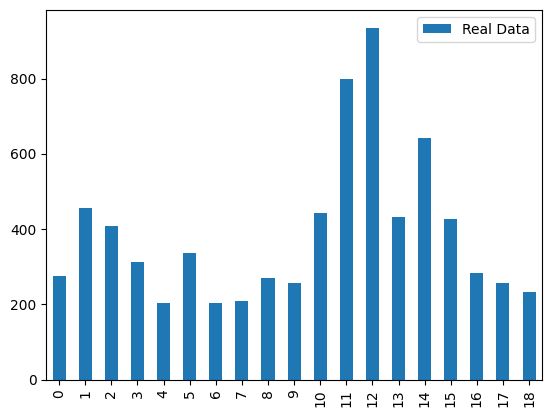

In [ ]:
xgb_res.plot.bar()

### XBoost со стандартизацией

In [ ]:
ho_pred_1 = xgb_h_sc.predict(ho_data)
ho_pred_1i = sc_h.inverse_transform(ho_pred_1.reshape(-1,1))
ho_pred_1i = ho_pred_1i.flatten()
print(ho_pred_1i)
print_metrics(ho_pred_1i, ho_label)

[231.25148 393.5929  270.51825 252.60796 258.94055 250.37073 232.9554
 296.20154 215.20149 272.23187 287.08923 384.7686  239.8394  197.45781
 174.0242  244.21535 273.4877  283.27756 283.09433]
Mean absolute error: 150.646
Mean squared error: 54755.294
Root mean squared error: 233.998


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_2 = xgb_hp_sc.predict(ho_data)
ho_pred_2i = sc_hp.inverse_transform(ho_pred_2.reshape(-1,1))
ho_pred_2i = ho_pred_2i.flatten()
print(ho_pred_2i)
print_metrics(ho_pred_2i, ho_label)

[398.51755 479.67896 284.33743 466.61752 352.4928  467.47043 391.832
 424.5315  392.35788 462.50952 390.01364 344.7803  411.6551  422.31018
 427.45355 388.7591  361.48828 307.77292 426.32257]
Mean absolute error: 160.436
Mean squared error: 42566.311
Root mean squared error: 206.316


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_3 = xgb_pp_sc.predict(ho_data)
ho_pred_3i = sc_pp.inverse_transform(ho_pred_3.reshape(-1,1))
ho_pred_3i = ho_pred_3i.flatten()
print(ho_pred_3i)
print_metrics(ho_pred_3i, ho_label)

[223.16008 203.32356 273.04175 202.38292 382.47568 210.83078 228.3035
 203.30005 208.31032 233.60687 233.83496 210.4343  195.14104 209.53177
 223.62047 224.35542 366.39255 375.77148 329.33652]
Mean absolute error: 192.074
Mean squared error: 72788.122
Root mean squared error: 269.793


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_4 = xgb_all_sc.predict(ho_data)
ho_pred_4i = sc_all.inverse_transform(ho_pred_4.reshape(-1,1))
ho_pred_4 = ho_pred_4i.flatten()
print(ho_pred_4i)
print_metrics(ho_pred_4i, ho_label)

NameError: name 'xgb_all_sc' is not defined

In [ ]:
ho_pred_5 = xgb_m_0_8_sc.predict(ho_data)
ho_pred_5i = sc_m_0_8.inverse_transform(ho_pred_5.reshape(-1,1))
ho_pred_5i = ho_pred_5i.flatten()
print(ho_pred_5i)
print_metrics(ho_pred_5i, ho_label)

[94.27862  95.47054  93.97052  90.057846 93.89993  89.96512  94.2903
 96.72253  91.43068  88.71413  94.000854 98.16554  95.11763  89.554886
 91.299126 90.7834   91.37537  94.303925 91.08711 ]
Mean absolute error: 295.869
Mean squared error: 126566.539
Root mean squared error: 355.762


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_6 = xgb_m_8_25_sc.predict(ho_data)
ho_pred_6i = sc_m_8_25.inverse_transform(ho_pred_6.reshape(-1,1))
ho_pred_6i = ho_pred_6i.flatten()
print(ho_pred_6i)
print_metrics(ho_pred_6i, ho_label)

[907.36456 946.7587  873.4238  861.29755 935.4829  868.9703  950.69147
 908.8914  763.54944 788.4756  939.75256 895.6715  861.4969  764.01965
 770.2156  923.3816  907.67865 892.66235 885.8872 ]
Mean absolute error: 495.194
Mean squared error: 284320.136
Root mean squared error: 533.217


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
xgb_res = pd.DataFrame(list(zip(ho_label, ho_pred_1i, ho_pred_2i, ho_pred_3i, ho_pred_4i)), columns=['Real Data', 'XBoost Hilic', 'XBoost Hilic Positive', 'XBoost Plasma Positive', 'All Data'])

In [ ]:
xgb_res['MEAN'] = xgb_res.mean(axis=1)

TypeError: Could not convert [array([52715.723], dtype=float32) array([52902.082], dtype=float32)
 array([48806.], dtype=float32) array([41698.023], dtype=float32)
 array([56864.105], dtype=float32) array([45632.633], dtype=float32)
 array([51454.62], dtype=float32) array([45037.055], dtype=float32)
 array([41273.87], dtype=float32) array([55086.875], dtype=float32)
 array([52021.05], dtype=float32) array([45521.855], dtype=float32)
 array([43730.703], dtype=float32) array([39592.727], dtype=float32)
 array([41852.15], dtype=float32) array([52488.832], dtype=float32)
 array([54118.836], dtype=float32) array([54600.242], dtype=float32)
 array([53066.098], dtype=float32)] to numeric

<Axes: >

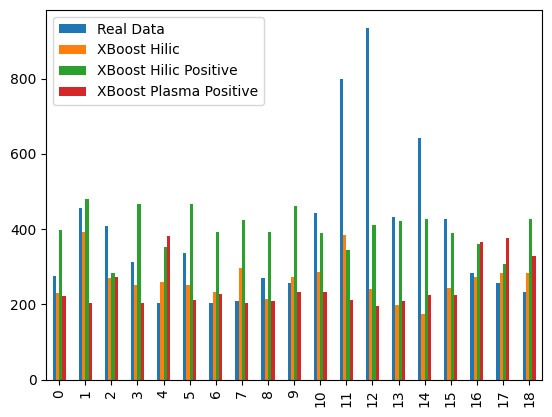

In [ ]:
xgb_res.plot.bar()

### LigtGBM без стандартизации



In [ ]:
ho_pred_1 = l_h.predict(ho_data)
ho_pred_1i = sc_h.inverse_transform(ho_pred_1.reshape(-1,1))
ho_pred_1 = ho_pred_1.flatten()
print(ho_pred_1)
print_metrics(ho_pred_1, ho_label)

[333.81760001 277.76150323 270.07881801 140.62358577 194.46002593
 189.33142018 277.64680696 316.52435423 194.8879516  217.85751088
 282.55664613 393.16033221 211.63196814 150.57419999 206.39871289
 273.29364127 212.83128123 287.45822528 281.59138694]
Mean absolute error: 173.873
Mean squared error: 60209.714
Root mean squared error: 245.377


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_2 = l_hp.predict(ho_data)
ho_pred_2i = sc_hp.inverse_transform(ho_pred_2.reshape(-1,1))
ho_pred_2 = ho_pred_2.flatten()
print(ho_pred_2)
print_metrics(ho_pred_2, ho_label)

[365.03855289 459.08714507 353.22022593 467.08801386 421.59177344
 385.05270529 352.79487766 459.11088125 441.28932848 455.4291779
 352.79487766 435.1369779  357.36115344 385.16761826 402.18131248
 356.46576093 391.47609478 388.93404168 450.00837897]
Mean absolute error: 167.399
Mean squared error: 44863.043
Root mean squared error: 211.809


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_3 = l_pp.predict(ho_data)
ho_pred_3i = sc_pp.inverse_transform(ho_pred_3.reshape(-1,1))
ho_pred_3 = ho_pred_3.flatten()
print(ho_pred_3)
print_metrics(ho_pred_3, ho_label)

[213.16172871 126.618268   219.92552097 134.50064246 372.31484473
 121.6870285  213.16172871 188.42541071 115.71857771 183.91825011
 213.16172871 203.9985603  158.0787862   69.42995282 196.68855455
 213.16172871 370.3004923  339.60173526 343.77727669]
Mean absolute error: 226.457
Mean squared error: 89277.419
Root mean squared error: 298.793


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_4 = l_all.predict(ho_data)
ho_pred_4i = sc_all.inverse_transform(ho_pred_4.reshape(-1,1))
ho_pred_4 = ho_pred_4.flatten()
print(ho_pred_4)
print_metrics(ho_pred_4, ho_label)

[378.91650712 298.20584118 298.98247213  95.74392514 346.45327604
 210.29688677 239.31356021 229.66673416 236.07122119 273.03700926
 265.7678117  240.44178186 282.87900526 189.09648289 234.90983951
 294.35476356 361.00795598 308.64224274 434.08844891]
Mean absolute error: 182.020
Mean squared error: 62807.885
Root mean squared error: 250.615


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_5 = l_m_0_8.predict(ho_data)
ho_pred_5i = sc_m_0_8.inverse_transform(ho_pred_5.reshape(-1,1))
ho_pred_5 = ho_pred_5.flatten()
print(ho_pred_5)
print_metrics(ho_pred_5, ho_label)

[ 90.65851773  91.58550562 100.2222809   91.66904568  98.42029025
  89.6685177   90.65851773  97.07617859  88.19831052  87.8766236
  90.65851773  99.08220258  94.28550621  89.86760723  88.65611999
  90.65851773  96.03539621  95.33224076  96.10201822]
Mean absolute error: 295.752
Mean squared error: 126706.180
Root mean squared error: 355.958


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_6 = l_m_8_25.predict(ho_data)
ho_pred_6i = sc_m_8_25.inverse_transform(ho_pred_6.reshape(-1,1))
ho_pred_6 = ho_pred_6.flatten()
print(ho_pred_6)
print_metrics(ho_pred_6, ho_label)

[848.3992711  917.14327684 856.12236332 829.42737169 958.76772784
 840.34857161 911.91754967 841.62976217 799.78118248 644.39690909
 911.91754967 965.48337266 948.72156485 710.69031571 719.85140803
 899.10913484 844.16221845 889.79661706 909.66211686]
Mean absolute error: 466.386
Mean squared error: 257336.212
Root mean squared error: 507.283


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
l_res = pd.DataFrame(list(zip(ho_label, ho_pred_1i, ho_pred_2i, ho_pred_3i, ho_pred_4i)), columns=['Real Data', 'LightGBM Hilic', 'LightGBM Hilic Positive', 'LightGBM Plasma Positive', 'All Data'])

In [ ]:
l_res['MEAN'] = l_res.mean(axis=1)

TypeError: Could not convert [array([185814.08370208]) array([164932.70152436])
 array([161944.25318724]) array([111518.90228522]) array([182378.0282728])
 array([126638.8585173]) array([152715.95208631]) array([167504.36049808])
 array([137592.03112076]) array([156893.47377892])
 array([157974.94941711]) array([181627.9814307]) array([143419.21505107])
 array([110814.60435957]) array([144453.03300007])
 array([161370.11880454]) array([184032.43425072])
 array([184378.15905017]) array([211009.51010556])] to numeric

<Axes: >

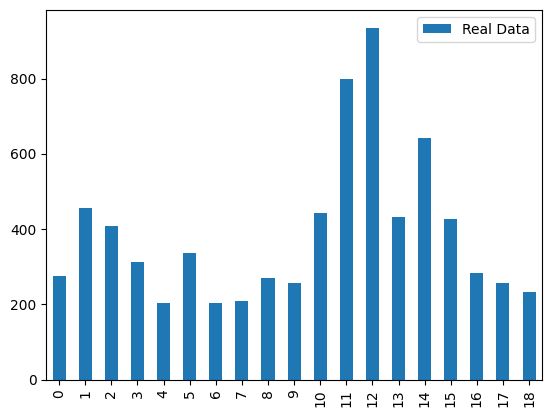

In [ ]:
l_res.plot.bar()

### LigtGBM со стандартизацией



In [ ]:
ho_pred_1 = l_h_sc.predict(ho_data)
ho_pred_1i = sc_h.inverse_transform(ho_pred_1.reshape(-1,1))
ho_pred_1i = ho_pred_1i.flatten()
print(ho_pred_1i)
print_metrics(ho_pred_1i, ho_label)

[333.81760106 277.76150472 270.07881922 140.62358439 194.46002455
 189.33142205 277.64681017 316.52435063 194.88795007 217.85751101
 282.55664997 393.16033167 211.63196818 150.57420124 206.39871206
 273.2936439  212.83128425 287.45822572 281.59138538]
Mean absolute error: 173.873
Mean squared error: 60209.714
Root mean squared error: 245.377


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_2 = l_hp_sc.predict(ho_data)
ho_pred_2i = sc_hp.inverse_transform(ho_pred_2.reshape(-1,1))
ho_pred_2i = ho_pred_2i.flatten()
print(ho_pred_2i)
print_metrics(ho_pred_2i, ho_label)

[365.03855065 459.08714488 353.22022413 467.08801204 421.59177389
 385.05270251 352.79487528 459.11087988 441.2893273  455.42918132
 352.79487528 435.13697636 357.3611523  385.16761615 402.18131307
 356.46575874 391.47609428 388.93404121 450.00837696]
Mean absolute error: 167.399
Mean squared error: 44863.043
Root mean squared error: 211.809


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_3 = l_pp_sc.predict(ho_data)
ho_pred_3i = sc_pp.inverse_transform(ho_pred_3.reshape(-1,1))
ho_pred_3i = ho_pred_3i.flatten()
print(ho_pred_3i)
print_metrics(ho_pred_3i, ho_label)

[213.16173151 126.61827193 219.92552051 134.50064461 372.31484225
 121.6870321  213.16173151 188.42541526 115.71858185 183.91824916
 213.16173151 203.99856325 158.07878905  69.4299539  196.68855534
 213.16173151 370.30048981 339.60173266 343.77727604]
Mean absolute error: 226.457
Mean squared error: 89277.418
Root mean squared error: 298.793


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_4 = l_all_sc.predict(ho_data)
ho_pred_4i = sc_all.inverse_transform(ho_pred_4.reshape(-1,1))
ho_pred_4i = ho_pred_4i.flatten()
print(ho_pred_3i)
print_metrics(ho_pred_4i, ho_label)

[213.16173151 126.61827193 219.92552051 134.50064461 372.31484225
 121.6870321  213.16173151 188.42541526 115.71858185 183.91824916
 213.16173151 203.99856325 158.07878905  69.4299539  196.68855534
 213.16173151 370.30048981 339.60173266 343.77727604]
Mean absolute error: 182.020
Mean squared error: 62807.885
Root mean squared error: 250.615


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_5 = l_m_0_8.predict(ho_data)
ho_pred_5i = sc_m_0_8.inverse_transform(ho_pred_5.reshape(-1,1))
ho_pred_5 = ho_pred_5.flatten()
print(ho_pred_5)
print_metrics(ho_pred_5, ho_label)

[ 90.65851773  91.58550562 100.2222809   91.66904568  98.42029025
  89.6685177   90.65851773  97.07617859  88.19831052  87.8766236
  90.65851773  99.08220258  94.28550621  89.86760723  88.65611999
  90.65851773  96.03539621  95.33224076  96.10201822]
Mean absolute error: 295.752
Mean squared error: 126706.180
Root mean squared error: 355.958


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_6 = l_m_8_25.predict(ho_data)
ho_pred_6i = sc_m_8_25.inverse_transform(ho_pred_6.reshape(-1,1))
ho_pred_6 = ho_pred_6.flatten()
print(ho_pred_6)
print_metrics(ho_pred_6, ho_label)

[848.3992711  917.14327684 856.12236332 829.42737169 958.76772784
 840.34857161 911.91754967 841.62976217 799.78118248 644.39690909
 911.91754967 965.48337266 948.72156485 710.69031571 719.85140803
 899.10913484 844.16221845 889.79661706 909.66211686]
Mean absolute error: 466.386
Mean squared error: 257336.212
Root mean squared error: 507.283


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
l_res = pd.DataFrame(list(zip(ho_label, ho_pred_1i, ho_pred_2i, ho_pred_3i, ho_pred_4i)), columns=['Real Data', 'LightGBM Hilic', 'LightGBM Hilic Positive', 'LightGBM Plasma Positive', 'All Data'])

In [ ]:
l_res['MEAN'] = l_res.mean(axis=1)

<Axes: >

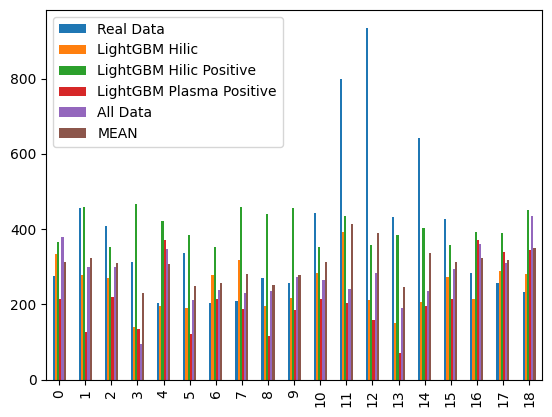

In [ ]:
l_res.plot.bar()

### Random Forest без стандартизации

In [ ]:
ho_pred_1 = rf_h.predict(ho_data)
ho_pred_1i = sc_h.inverse_transform(ho_pred_1.reshape(-1,1))
ho_pred_1 = ho_pred_1.flatten()
print(ho_pred_1)
print_metrics(ho_pred_1, ho_label)

[321.9346908  405.0366078  267.6207858  237.52814166 257.9707198
 216.30656074 232.743606   274.5364194  203.18127336 259.19707047
 264.516291   388.7327922  268.69708098 233.42814138 159.46356696
 318.938214   318.42715878 336.8481858  347.05049478]
Mean absolute error: 153.645
Mean squared error: 52932.756
Root mean squared error: 230.071


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_2 = rf_hp.predict(ho_data)
ho_pred_2i = sc_hp.inverse_transform(ho_pred_2.reshape(-1,1))
ho_pred_2 = ho_pred_2.flatten()
print(ho_pred_2)
print_metrics(ho_pred_2, ho_label)

[411.6454     548.89916    321.79911    431.32618571 402.93223
 441.08319    418.61442    442.14395    410.27544    428.85503571
 370.59297    397.00673    455.13588    423.61652    432.8495
 441.6937     361.96318    351.94435    446.38536   ]
Mean absolute error: 161.619
Mean squared error: 39470.356
Root mean squared error: 198.671


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_3 = rf_pp.predict(ho_data)
ho_pred_3i = sc_pp.inverse_transform(ho_pred_3.reshape(-1,1))
ho_pred_3 = ho_pred_3.flatten()
print(ho_pred_3)
print_metrics(ho_pred_3, ho_label)

[230.51851429 164.41521429 253.9086     178.7192     358.6476
 177.0015     248.11662857 187.7594     194.50934286 229.1179
 252.34491429 200.79842857 186.5682     196.05364286 200.3331
 235.83982857 370.1493     361.85       373.8056619 ]
Mean absolute error: 202.457
Mean squared error: 77199.995
Root mean squared error: 277.849


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_4 = rf_all.predict(ho_data)
ho_pred_4i = sc_all.inverse_transform(ho_pred_4.reshape(-1,1))
ho_pred_4 = ho_pred_4.flatten()
print(ho_pred_4)
print_metrics(ho_pred_4, ho_label)

[341.3185288  377.2015332  254.9104633  167.32178098 368.3982782
 208.1909701  277.5533826  268.61246945 261.85005573 282.39234668
 267.7028966  325.3406112  322.98023828 182.90039487 199.4909859
 316.8612654  280.638435   352.477014   422.4410304 ]
Mean absolute error: 170.832
Mean squared error: 55379.340
Root mean squared error: 235.328


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_5 = rf_m_0_8.predict(ho_data)
ho_pred_5i = sc_m_0_8.inverse_transform(ho_pred_5.reshape(-1,1))
ho_pred_5 = ho_pred_5.flatten()
print(ho_pred_5)
print_metrics(ho_pred_5, ho_label)

[ 92.78266667  93.313       92.417       89.543       98.534
  88.528       94.06166667 103.345       89.095       87.4355
  91.868      105.642       99.69288889  90.662       97.50453333
  85.209       98.111       95.885       99.097     ]
Mean absolute error: 294.383
Mean squared error: 125369.637
Root mean squared error: 354.076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_6 = rf_m_8_25.predict(ho_data)
ho_pred_6i = sc_m_8_25.inverse_transform(ho_pred_6.reshape(-1,1))
ho_pred_6 = ho_pred_6.flatten()
print(ho_pred_6)
print_metrics(ho_pred_6, ho_label)

[ 980.889  865.043  909.128  899.149  927.966  879.209  999.263  965.022
  834.555  768.907 1025.14   951.515  923.37   751.528  728.03  1011.382
  902.604  881.157  885.349]
Mean absolute error: 512.025
Mean squared error: 309097.969
Root mean squared error: 555.966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
rf_res = pd.DataFrame(list(zip(ho_label, ho_pred_1i, ho_pred_2i, ho_pred_3i, ho_pred_4i)), columns=['Real Data', 'LightGBM Hilic', 'LightGBM Hilic Positive', 'LightGBM Plasma Positive', 'All Data'])

In [ ]:
rf_res['MEAN'] = rf_res.mean(axis=1)

TypeError: Could not convert [array([185416.30877798]) array([213908.66657755])
 array([154747.28362912]) array([140019.75200391])
 array([192720.08447685]) array([143920.3543909]) array([163122.91156263])
 array([164529.71460192]) array([148522.18520278])
 array([167402.35719554]) array([161914.682418]) array([189436.23577944])
 array([174302.40674567]) array([143014.49922311])
 array([135025.34741617]) array([185378.16309597])
 array([185498.84678986]) array([197804.06568273])
 array([223211.12858977])] to numeric

<Axes: >

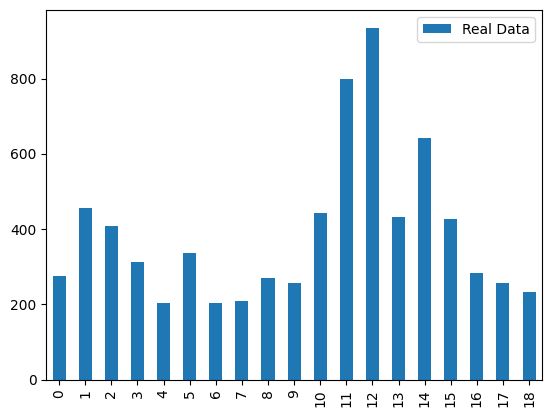

In [ ]:
rf_res.plot.bar()

### Random Forest со стандартизацией

In [ ]:
ho_pred_1 = rf_h_sc.predict(ho_data)
ho_pred_1i = sc_h.inverse_transform(ho_pred_1.reshape(-1,1))
ho_pred_1i = ho_pred_1i.flatten()
print(ho_pred_1i)
print_metrics(ho_pred_1i, ho_label)

[295.581273   406.9933278  272.113119   231.8164494  244.829886
 225.54929188 228.156906   289.4875098  217.80456078 254.40901047
 274.2486612  398.5997496  270.98326194 220.65738072 159.33058196
 301.469604   308.8487694  336.524667   344.12276418]
Mean absolute error: 150.715
Mean squared error: 52311.888
Root mean squared error: 228.718


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_2 = rf_hp_sc.predict(ho_data)
ho_pred_2i = sc_hp.inverse_transform(ho_pred_2.reshape(-1,1))
ho_pred_2i = ho_pred_2i.flatten()
print(ho_pred_2i)
print_metrics(ho_pred_2i, ho_label)

[406.45205    548.44992    327.43038    429.679      398.96697
 435.075279   412.48422    443.47515    411.94022    439.22323571
 362.35692    386.85651    457.3668     430.883984   438.55105
 427.80913    368.71933    349.53538    456.96928   ]
Mean absolute error: 161.018
Mean squared error: 39815.912
Root mean squared error: 199.539


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_3 = rf_pp_sc.predict(ho_data)
ho_pred_3i = sc_pp.inverse_transform(ho_pred_3.reshape(-1,1))
ho_pred_3i = ho_pred_3i.flatten()
print(ho_pred_3i)
print_metrics(ho_pred_3i, ho_label)

[233.90791429 156.972      241.3732     165.3767     361.7296
 160.8951     247.14331429 178.40782857 187.6217     225.601
 252.22002857 193.87622857 180.09342857 189.91594286 193.945
 241.60231429 376.677      373.557      376.2932619 ]
Mean absolute error: 208.189
Mean squared error: 79776.466
Root mean squared error: 282.447


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_4 = rf_all_sc.predict(ho_data)
ho_pred_4i = sc_all.inverse_transform(ho_pred_4.reshape(-1,1))
ho_pred_4i = ho_pred_4i.flatten()
print(ho_pred_3i)
print_metrics(ho_pred_4i, ho_label)

[233.90791429 156.972      241.3732     165.3767     361.7296
 160.8951     247.14331429 178.40782857 187.6217     225.601
 252.22002857 193.87622857 180.09342857 189.91594286 193.945
 241.60231429 376.677      373.557      376.2932619 ]
Mean absolute error: 167.412
Mean squared error: 54410.343
Root mean squared error: 233.260


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_5 = rf_m_0_8.predict(ho_data)
ho_pred_5i = sc_m_0_8.inverse_transform(ho_pred_5.reshape(-1,1))
ho_pred_5i = ho_pred_5i.flatten()
print(ho_pred_5i)
print_metrics(ho_pred_5i, ho_label)

[2490.79269047 2504.51101373 2481.33385916 2406.99106647 2639.56450039
 2380.73569605 2523.87704393 2764.01236944 2395.40248918 2352.47560523
 2467.13267851 2823.4296954  2669.5418965  2435.93664233 2612.9349155
 2294.88192815 2628.6226071  2571.0418637  2654.12782408]
Mean absolute error: 2142.702
Mean squared error: 4632567.361
Root mean squared error: 2152.340


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ho_pred_6 = rf_m_8_25.predict(ho_data)
ho_pred_6i = sc_m_8_25.inverse_transform(ho_pred_6.reshape(-1,1))
ho_pred_6i = ho_pred_6i.flatten()
print(ho_pred_6i)
print_metrics(ho_pred_6i, ho_label)

[172083.23298559 151855.18276275 159552.93317342 157810.48446415
 162842.26565014 154328.73005361 175291.5457007  169312.67143935
 146531.62566804 135068.72629276 179809.96891442 166954.19316337
 162039.75094247 132034.15207506 127931.12975115 177407.66313808
 158413.76738734 154668.87336313 155400.84500249]
Mean absolute error: 157471.144
Mean squared error: 25003093432.380
Root mean squared error: 158123.665


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
rf_res = pd.DataFrame(list(zip(ho_label, ho_pred_1i, ho_pred_2i, ho_pred_3i, ho_pred_4i)), columns=['Real Data', 'LightGBM Hilic', 'LightGBM Hilic Positive', 'LightGBM Plasma Positive', 'All Data'])

In [ ]:
rf_res['MEAN'] = rf_res.mean(axis=1)

<Axes: >

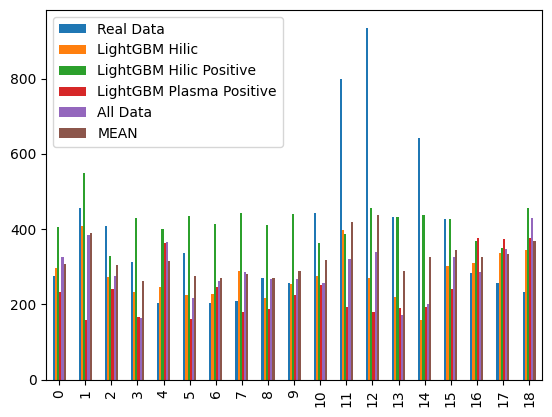

In [ ]:
rf_res.plot.bar()